# Assignment Summary

**Denoising autoencoders**: We will evaluate denoising autoencoders applied to the MNIST dataset.

* Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a denoising autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set. You should use at least three layers in the encoder and in the decoder.
* We now need to determine how well this autoencoder works. For each image in the MNIST test dataset, compute the residual error of the autoencoder. This is the difference between the true image and the reconstruction of that image by the autoencoder. It is an image itself. Prepare a figure showing the mean residual error, and the first five principal components. Each is an image. You should preserve signs (i.e. the mean residual error may have negative as well as positive entries). The way to show these images most informatively is to use a mid gray value for zero, then darker values for more negative image values and lighter values for more positive values. The scale you choose matters. You should show
    * mean and five principal components on the same gray scale for all six images, chosen so the largest absolute value over all six images is full dark or full light respectively and
    * mean and five principal components on a scale where the gray scale is chosen for each image separately.

**Variational autoencoders**: We will evaluate variational autoencoders applied to the MNIST dataset.
  * Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a variational autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set.
  * We now need to determine how well the codes produced by this autoencoder can be interpolated.
    * For 10 pairs of MNIST test images of the same digit, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.
    * For 10 pairs of MNIST test images of different digits, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

**Hints and References**: For the denoising autoencoder, there is an abundance of code online should you choose to obtain one. It may be a good practice to also implement this part from scratch and test what you learned in the CNN assignment. All you have to do is define a network with two groups of layers:
  * *Encoder Layers*: This part must take an image and produce a low-dimensional "code" of the image. Therefore, the architecture of the netwok must be narrowing down. Let's call this function $f^{\text{encoder}}$.
  * *Decoder Layers*: This part must take a low-dimensional "code" of the image and produce the original image. Therefore, the architecture of the netwok must be expanding. Let's call this function $f^{\text{decoder}}$.
  
All you have to do is to try and write some code to minimize the following loss:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^N \|x_i - f^{\text{decoder}}(f^{\text{encoder}}(x_i))\|_2^2$$

You may pick any architecture that works as long as it has three layes. The MNIST data has 784 pixels. Therefore, a fully connected network which takes 784 reshaped dimensions to $h_1$ dimensions, then to $h_2$ dimensions, and finally to $h_3$ dimensions is an excellent starting point for an encoder. A vast range of choices can work for these three numbers, but just to give you an idea about their plausible range of values, $h_1$ could be in the order of hundreds, $h_2$ could be in order of tens (or at most a few hundreds), and $h_3$ is supposed to be a low-dimension (preferrably under 10 or at most 20).

You can reverse the encoder architecture, to obtain a decoder, and then stack an SGD optimizer on top with default hyper-parameters to train your denoising autoencoder. You must be familiar with the rest of the concepts from earlier assignments such as multi-dimensional scalings and PCA. You also would need to write some basic code to visualize using matplotlib, PIL, etc.

For VAEs, you may also be able to implement everything from scratch once you review the material. However, there are a lot of resources and examples for implementing VAEs, and here we share a few of them:

  1. Pytorch Tutorials has an example for training VAEs at https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py
  2. Another pytorch example for VAEs can be found at https://github.com/pytorch/examples/blob/master/vae/main.py
  3. Pyro is a library for bayesian optimization and is based on pytorch, which has a detailed tutorial on how to train VAEs with some high-level story of the math involved https://pyro.ai/examples/vae.html
  4. BoTorch is another bayesian optimization library based based on pytorch and has some tutorials for implementing VAEs https://botorch.org/tutorials/vae_mnist
  5. If you're a tensorflow fan, you may find some tutorial at https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE or  https://www.tensorflow.org/tutorials/generative/cvae
  6. Keras fans can also see https://keras.io/examples/generative/vae/
  7. etc.
  
The MNIST data is provided at `../VAE-lib/data_mnist` so that you could use the `torchvision` API for loading the data just like the previous assignment.

**Important Note**: This assignment will not be automatically graded and is optional. Therefore, do not expect meaninful grades to be published upon or after submission. However, please make sure to submit your work if you expect it to be reviewed by the instructors for any reason. We will consider the latest submission of your work. 

Any work that is not submitted will not be viewed by us.

In [40]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import botorch
import pyro
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

In [41]:
# Load MNIST dataset

trainset = torchvision.datasets.MNIST(root='../VAE-lib/data_mnist', train=True, download=False)
testset = torchvision.datasets.MNIST(root='../VAE-lib/data_mnist', train=False, download=False)

In [42]:
def add_noise(img,noise_type="gaussian"):
    
    row,col = 28,28
    imgArray = np.array(img).astype(np.float32)
    
    if noise_type=="gaussian":
        mean = 0
        var = 10
        sigma = var**.5
        noise = np.random.normal(mean, sigma, imgArray.shape)
        noise = noise.reshape(row,col)
        imgArray = imgArray + noise
        
    return imgArray


# Add Gaussian noise to each image in trainset and testset

noisy_traindata = np.zeros((60000, 28, 28))
for i in range(len(trainset.data)):
    noisy_traindata[i] = add_noise(trainset.data[i]) # trainset.data contains images, trainset.targets contains labels
print("Gaussian Noises are added to all trainset images")

noisy_testdata = np.zeros((10000, 28, 28))
for i in range(len(testset.data)):
    noisy_testdata[i] = add_noise(testset.data[i])
print("Gaussian Noises are added to all testset images")


Gaussian Noises are added to all trainset images
Gaussian Noises are added to all testset images


In [43]:
# Define Audoencoder Model
class denoising_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(True),
            nn.Linear(256,64),
            nn.ReLU(True),
            nn.Linear(64,8),
            nn.ReLU(True)
        )
    
        self.decoder=nn.Sequential(
            nn.Linear(8,64),
            nn.ReLU(True),
            nn.Linear(64,256),
            nn.ReLU(True),
            nn.Linear(256,28*28),
            nn.Sigmoid(),
        )
        
    def forward(self,x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x
  

In [44]:
# Create dataset that includes both clean and noisy images
class noisedDataset(Dataset):
    def __init__(self,datasetnoised,datasetclean,labels,transform):
        self.noise=datasetnoised
        self.clean=datasetclean
        self.labels=labels
        self.transform=transform
    
    def __len__(self):
        return len(self.noise)
    
    def __getitem__(self,idx):
        xNoise=self.noise[idx]
        xClean=self.clean[idx]
        y=self.labels[idx]
    
        if self.transform != None:
            xNoise=self.transform(xNoise)
            xClean=self.transform(xClean)
            
        return (xNoise,xClean,y)

In [46]:
#tsfms = transforms.Compose([transforms.ToTensor()])
tsfms = None

noisy_trainset = noisedDataset(noisy_traindata, trainset.data, trainset.targets, tsfms)
noisy_testset = noisedDataset(noisy_testdata, testset.data, testset.targets, tsfms)

batch_size = 32

trainloader = DataLoader(noisy_trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(noisy_testset, batch_size=batch_size, shuffle=False)

In [47]:
# Train the model
model = denoising_model()
criterion=nn.MSELoss()
optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
losslist=list()

for epoch in range(80):
    print("Starting epoch ", epoch)
    running_loss = 0.0
    
    for i, data in enumerate(trainloader,0): 
        dirty, clean, label = data
        dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
        clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
        
        # forward pass
        output = model(dirty)
        loss=criterion(output,clean)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    current_epoch_mean_loss = running_loss/60000
    print("Current epoch mean loss: ", current_epoch_mean_loss)
    losslist.append(current_epoch_mean_loss)
                
print('Finished Training')

Starting epoch  0
Current epoch mean loss:  225.59388709309897
Starting epoch  1
Current epoch mean loss:  225.57675026041667
Starting epoch  2
Current epoch mean loss:  225.56827655436197
Starting epoch  3
Current epoch mean loss:  225.56365685221354
Starting epoch  4
Current epoch mean loss:  225.56247137044272
Starting epoch  5
Current epoch mean loss:  225.55727053222657
Starting epoch  6
Current epoch mean loss:  225.55459405110676
Starting epoch  7
Current epoch mean loss:  225.55413702799478
Starting epoch  8
Current epoch mean loss:  225.55385546061197
Starting epoch  9
Current epoch mean loss:  225.55362561035156
Starting epoch  10
Current epoch mean loss:  225.55336013183594
Starting epoch  11
Current epoch mean loss:  225.5531839029948
Starting epoch  12
Current epoch mean loss:  225.55297276204428
Starting epoch  13
Current epoch mean loss:  225.550031632487
Starting epoch  14
Current epoch mean loss:  225.5484129231771
Starting epoch  15
Current epoch mean loss:  225.54826

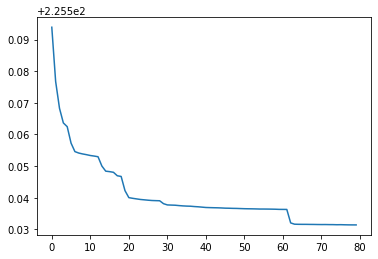

In [48]:
plt.plot(range(len(losslist)),losslist)